In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import math
import shutil   #for high-level file operations, like copying, moving, or removing files and directories
import glob     #which is used to find all the pathnames matching a specified pattern.
import zipfile




ROOT_DIR = 'D:/PCOS1/PCOS'
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
   number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))  #calculates number of items in subdirectory
   print("",dir,"" ,number_of_images[dir])

from keras.preprocessing.image import ImageDataGenerator    # augmenting image data and performing pre-processing in real-time
from keras.applications.mobilenet import preprocess_input

def preprocessingImage1(path):        # preprocessing images in batches of 32,zooming,shearing,resizing. for TRAINING
  image_data = ImageDataGenerator(zoom_range=0.2,shear_range=0.2,preprocessing_function= preprocess_input,horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

def preprocessionfImage2(path):      # for TESTING, VALIDATION
  # """
  # Input :path
  # Output : preprocessed Image
  # """
  image_data  = ImageDataGenerator(preprocessing_function= preprocess_input )
  image = image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

def datafolder(path,split):       #split the origional dataset folder and move images from there to the new folders
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                  size=(math.floor(split * number_of_images[dir])-5),replace=False):
      
          O = os.path.join(ROOT_DIR,dir,img)
          D = os.path.join("./"+path,dir)
          shutil.copy(O,D)
          os.remove(O)

  else:
     print("Folder already exist")

datafolder("train",0.7)         # divide the dataset into train, test, validate

datafolder("test",0.15)

datafolder("val",0.15)

path ='D:/Minor/PCOS1/train'      #preprocess the images of train using function1 and test, validate using function2
train_data = preprocessingImage1(path)

path ='D:/Minor/PCOS1/test'
test_data = preprocessionfImage2(path)

path = 'D:/Minor/PCOS1/val'
val_data = preprocessionfImage2(path)




import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
import keras

base_model = MobileNet(input_shape=(224,224,3),include_top=False)   # Base Model

for layer in base_model.layers:       # freeze the weights of the model
  layer.trainable = False

x= Flatten()(base_model.output)     # convert the output of base model from 2D to 1D
x= Dense(units=1,activation='sigmoid')(x)      # custom layer with 1 neuron using sigmoid function

# creates the final model by connecting the input of the base
# model (base_model.input) to the output of the new layers (x).
model = Model(base_model.input,x)

# model consists of the pre-trained MobileNet model 
# followed by your custom classification layers.

model.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

# setting up callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping
# saving the best model
mc = ModelCheckpoint(filepath="bestmodel.h5",monitor='val_accuracy',verbose=1,save_best_only=True)

#Early stopping
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1)

cb = [mc,es]

#training the model
hist = model.fit_generator(train_data,
                           steps_per_epoch=10,
                           epochs=30,
                           validation_data=val_data,
                           validation_steps=16,
                          callbacks=cb)

model = load_model("D:/Minor/PCOS1/bestmodel.h5")

#  Evaluating the Model on Test Data  to evaluate the model's performance on an unseen test dataset
acc = model.evaluate_generator(test_data)[1]
print(f"our model accuracy is  {acc * 100} %")

# h = hist.history
# h.keys()

train_data.class_indices

test_data.class_indices

val_data.class_indices

#now get some random images and predict the class
from keras.preprocessing import image
import tensorflow as tf

def predictimage(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    i = tf.keras.utils.img_to_array(img) / 255.0
    input_arr = np.array([i])

    # Make prediction
    pred = model.predict(input_arr)[0][0]  # Get single output value
    
    # Determine label based on prediction
    label = "Not Affected" if pred >= 0.5 else "Affected"  # assuming 0.5 threshold for binary classification
    print(f"Prediction: {label}, Confidence: {pred:.2f}")

    # Display image with label
    plt.imshow(input_arr[0])
    plt.title(f"Input Image - {label}")
    plt.show()
    
    return label, pred





#It is the infected image sample
label, pred = predictimage("C:/Users/divya/OneDrive/Desktop/infected2.jpg") 




#It is the not affected sample images
label, pred = predictimage("D:/Minor/PCOS/code 2.0/testing/pcos/img_0_113.jpg")




#not infected image
label, pred = predictimage("C:/Users/divya/OneDrive/Desktop/R.jpg")




predictimage("D:/Minor/PCOS1/test/notinfected/img_0_840.jpg")





# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import imutils
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, and the layer to be used to visualize activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer with 4D output 
        for layer in reversed(self.model.layers):
            if len(layer.output.shape) == 4:
                return layer.name

        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # create a new model with output both,feature map and final prediction
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations performed by Model on the variables
        with tf.GradientTape() as tape:
            # cast image to float-32 data type, pass the image through the gradient model, and grab the loss associated with the specific class index
            inputs = tf.cast(image, tf.float32)   #casting image into 32 bit float format for calculations in tensorflow
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # computes the partial derivative of the loss function with respect to each activation in convOutputs
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")   #array with only 1s(+ve) and 0s(-ve) 
        castGrads = tf.cast(grads > 0, "float32")     ##array with only 1s(+ve) and 0s(-ve) 
        guidedGrads = castConvOutputs * castGrads * grads     

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)
    



    # initialize our 'gradient class activation map and build the heatmap
# load the input image from disk (in Keras/TensorFlow format) and preprocess it
image = load_img("C:/Users/divya/OneDrive/Desktop/infected2.jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)



cam = GradCAM(model, classIdx=0)
heatmap = cam.compute_heatmap(image)




# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
orig = cv2.imread("C:/Users/divya/OneDrive/Desktop/infected2.jpg")
# resized = cv2.resize(orig, (224, 224))




# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)




# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2.imshow("Output", output)
cv2.waitKey(0)
cv2.destroyAllWindows()



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/PCOS1/PCOS'

1/1 [==============================] - 0s 34ms/step
Prediction: Affected, Confidence: 0.00


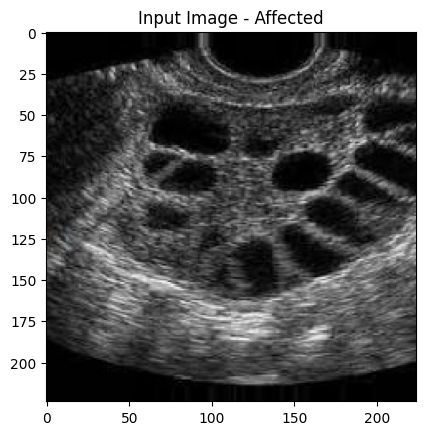

Affected


In [3]:
label, pred = predictimage("D:/Minor/PCOS/code 2.0/testing/pcos/img_0_113.jpg")
print (label)